# Image2Latex
## Project Goals:
- Build a system that can automatically decompile an image of an equation into latex or markdown.
- Build a codebase that features: 
    - CLI scripts to run experiments with different configurations
    - Log experiments results in weight and biases
    - Perform hyper-parameter sweeps via weights and biases
    - Build visualization tool to understand model performance on sample data. 
    - Build a docker image for the project
    - Host the project on AWS GPU (VM)
    - Unit and integration tests
    - Logging
    - Github actions for CI/CD 

## Project Description
**What dataset will you use, or how do you plan to collect data?**

The plan is to start with the IM2LATEX-100K dataset, but may move to collect my own dataset from sites such as mathOverflow.net in order to train the model on markdown syntax.

**What baseline will you use?**

The plan is to reproduce [this paper](https://arxiv.org/pdf/1609.04938v1.pdf). The paper uses CNN for text and layout recognition, in addition to an attention based neural translation system (based on LSTMs).

**What model architecture ?**

I plan to use encoder-decoder architecture as proposed in the paper. The encoder consists of a CNN, while the decoder consists of LSTM models with attention. I may try to improve the model by using transformers. 

**What loss function do you propose?**

Cross entropy loss 

**What will the end result look like?** 

A web endpoint where users can upload a photo and get a latex/markdown format. 

**What’s your stretch goal?**

 I would like to deploy this as a chrome extension that users can use to get the latex/md syntax of an equation in a paper they are browning and paste it directly in their editor.


## Setting up the project
My approach is to first develop the project on a small dataset using google colab. Once I am confident with my implementaion, I will move to training the model on the complete IM@LATEX-100K dataset using a more powerful infrastructure.  


### Setting up google colab

- We use google drive as file storage. Datasets as well as code base is stored there. 
- We use google colab GPU to run the code. 
- Github is used for code versioning. 

In [ ]:
!pip install python-dotenv
!pip install wandb -qqq

In [ ]:
#setup colab
%load_ext autoreload
%autoreload 2

#set up working directory (google drive)
%cd /content/drive/MyDrive/im2latex

#load credentials
import os
from dotenv import load_dotenv
load_dotenv()
Password = os.getenv("Password")
Username =os.getenv("Username")
REPO = os.getenv("REPO")
EMAIL = os.getenv("EMAIL")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/content/drive/MyDrive/im2latex


In [ ]:
#configuring weights and biases
!wandb init -p im2latex

## Dataset

### Prepare small sample dataset (to be used while development)
The scripts to preprocess the data were adopted from https://github.com/harvardnlp/im2markup.git.
The sample dataset consists of 1200 raw images along with their latex markup. The images are cropped, padded, and downsampled using the below scripts.
The latex markup are normalized and filter (some samples are discarded if they did not fit a criteria like the max allowed markup length.) 


In [ ]:
#%cd /content/drive/MyDrive/im2latex/im2markup

In [ ]:
!ls /content/drive/MyDrive/im2latex/im2markup/data/sample/images | wc -l

1200


In [ ]:
#!python scripts/preprocessing/preprocess_images.py --input-dir data/sample/images --output-dir data/sample/images_processed

### Raw Image

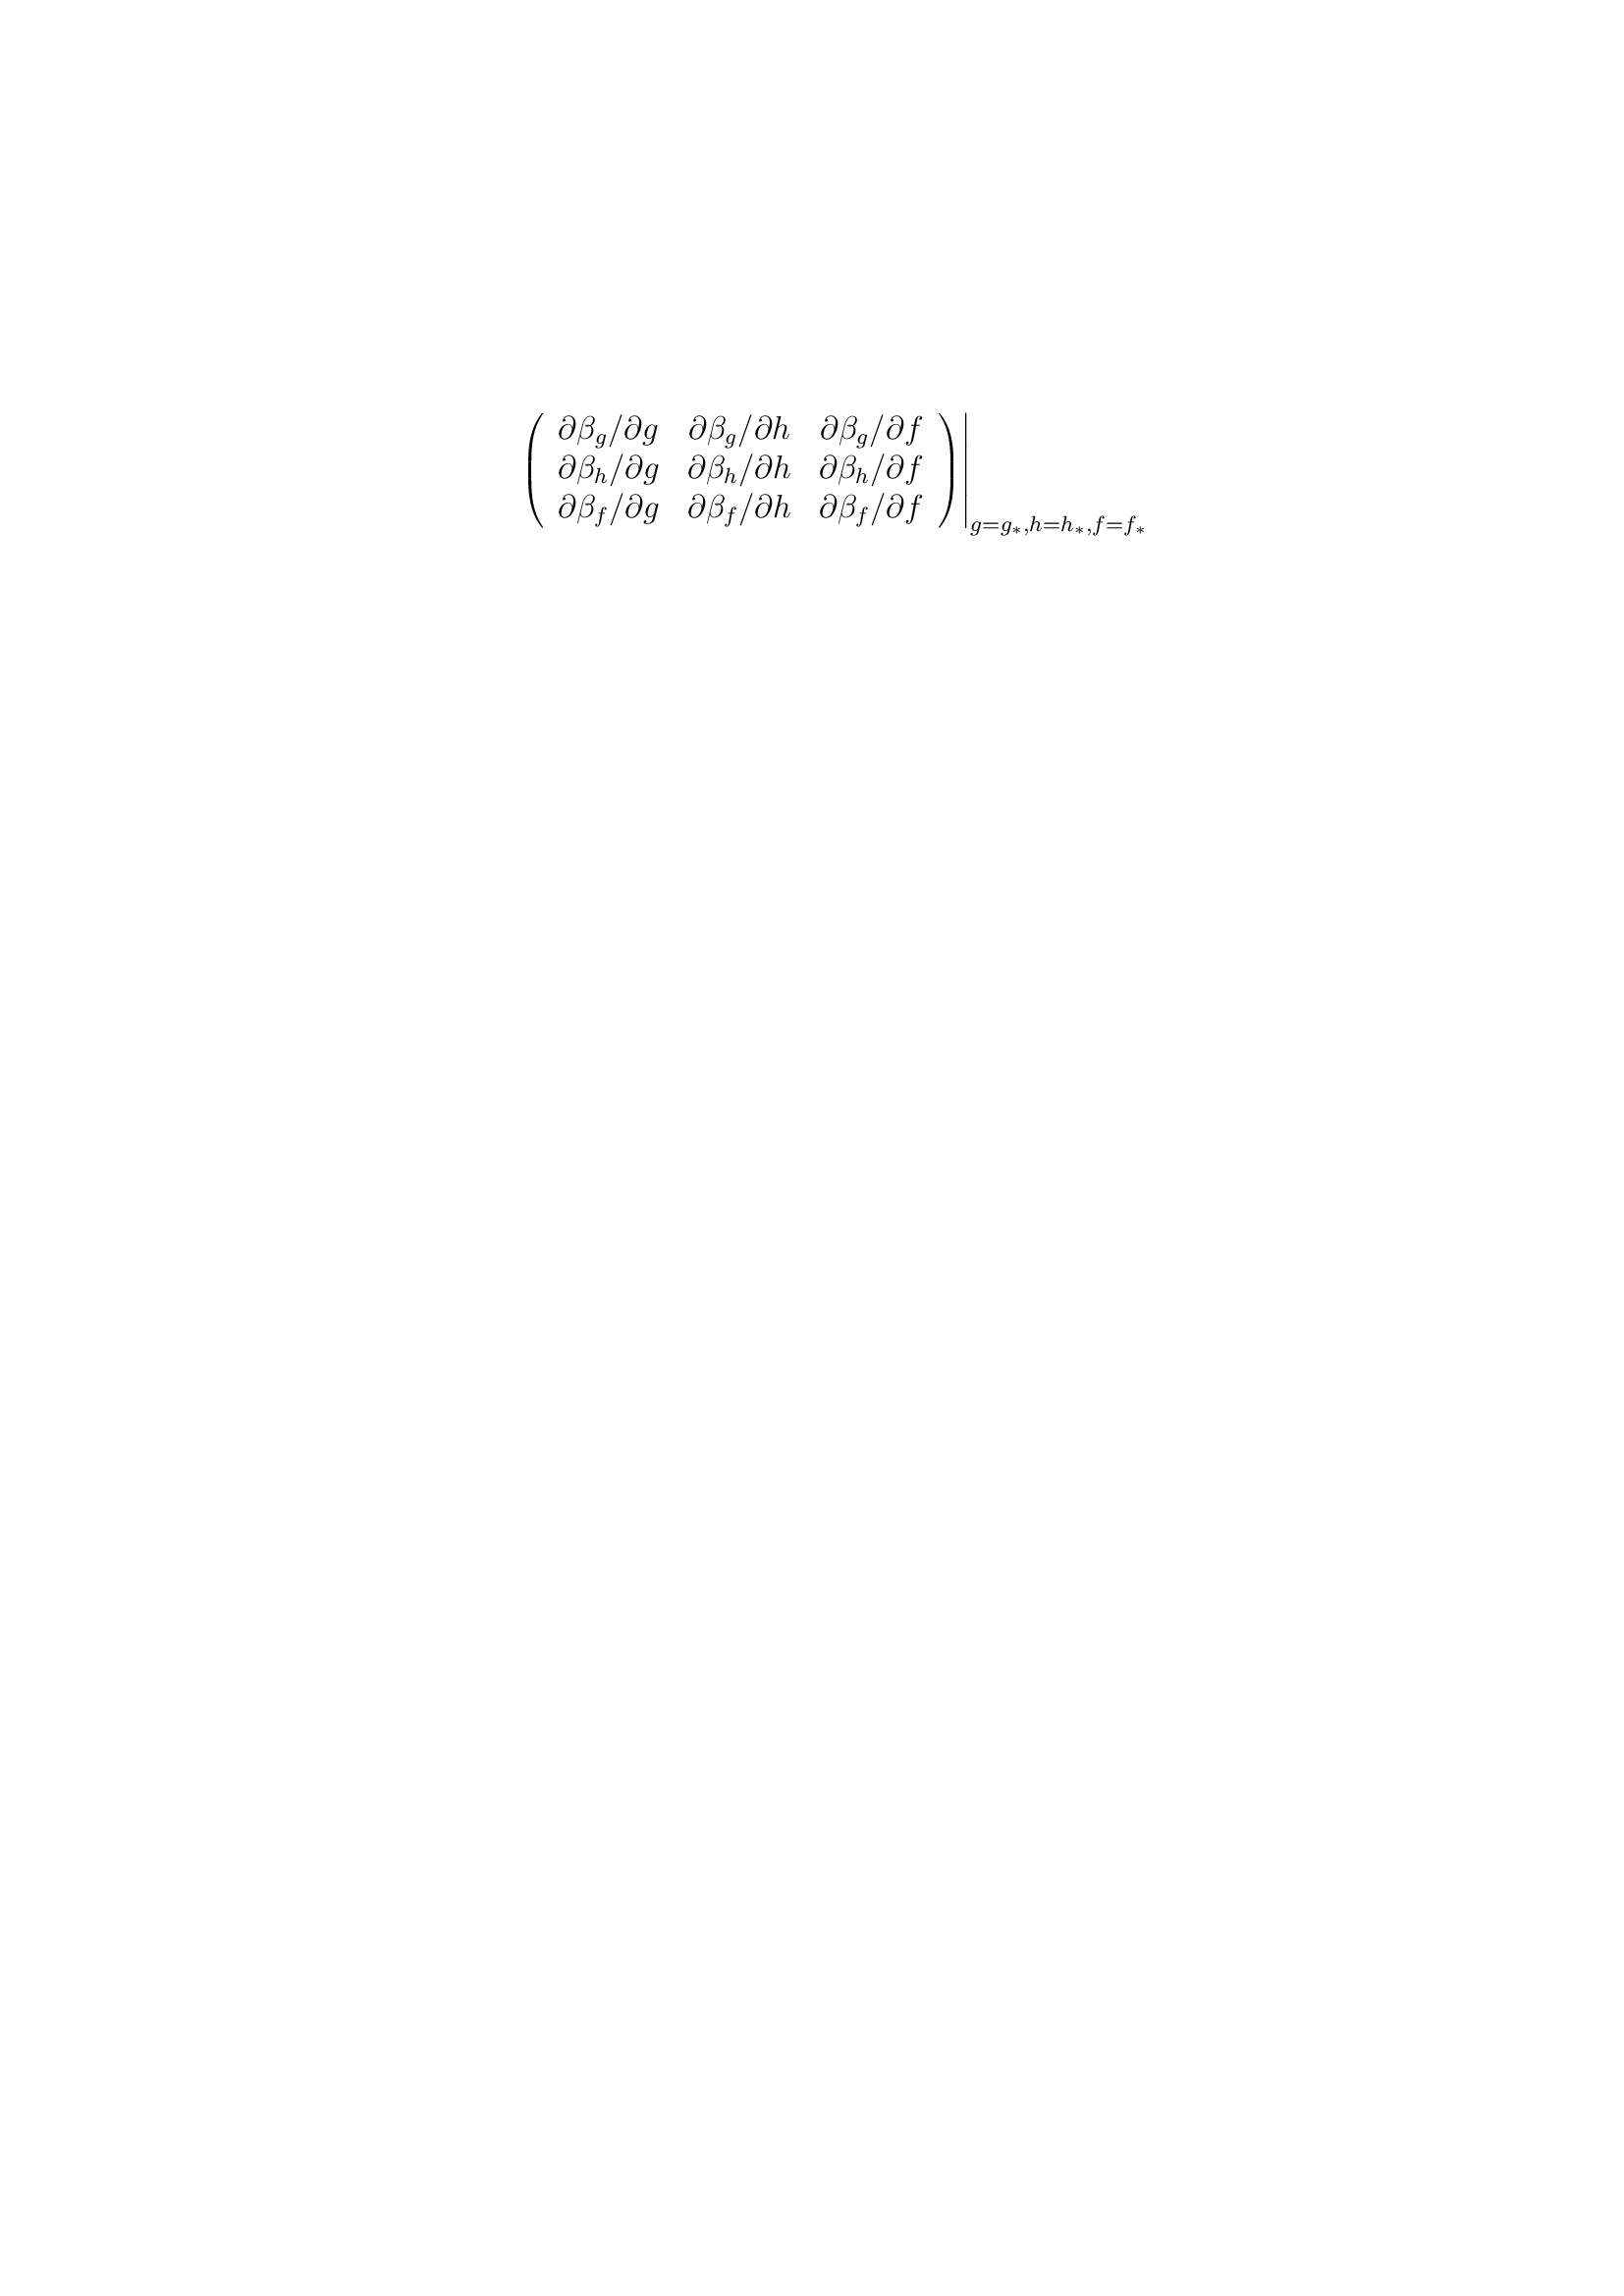

### Processed Image

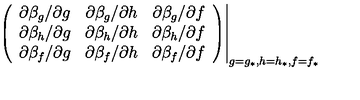

In [ ]:
raw_imgpath = "/content/drive/MyDrive/im2latex/im2markup/data/sample/images/1015942522.png"
processed_imgpath = "/content/drive/MyDrive/im2latex/im2markup/data/sample/images_processed/1015942522.png"
display(Markdown('### Raw Image'))
display(Image(filename=raw_imgpath,width=300))
display(Markdown('### Processed Image'))
display(Image(filename=processed_imgpath))

In [ ]:
#!python scripts/preprocessing/preprocess_formulas.py --mode normalize --input-file data/sample/formulas.lst --output-file data/sample/formulas.norm.lst

In [ ]:
labels_file = "/content/drive/MyDrive/im2latex/im2markup/data/sample/formulas.lst"
f = open(labels_file)
labels = f.readlines()
f.close()
display(Markdown('\n### Label'))
print(labels[0])
labels_file = "/content/drive/MyDrive/im2latex/im2markup/data/sample/formulas.norm.lst"
f = open(labels_file)
labels_norm = f.readlines()
f.close()
display(Markdown('\n### Normalized  Label'))
print(labels_norm[0])


### Label

ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .\label{eq:sps1}




### Normalized  Label

d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } \lbrace d r ^ { 2 } + r ^ { 2 } d \theta ^ { 2 } + r ^ { 2 } s i n ^ { 2 } \theta d \varphi ^ { 2 } \rbrace - { \frac { d t ^ { 2 } } { ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } } } \, .



In [ ]:
#!python scripts/preprocessing/preprocess_filter.py --filter --image-dir data/sample/images_processed --label-path data/sample/formulas.norm.lst --data-path data/sample/train.lst --output-path data/sample/train_filter.lst 

In [ ]:
#!python scripts/preprocessing/preprocess_filter.py --filter --image-dir data/sample/images_processed --label-path data/sample/formulas.norm.lst --data-path data/sample/validate.lst --output-path data/sample/validate_filter.lst 

In [ ]:
#!python scripts/preprocessing/preprocess_filter.py --no-filter --image-dir data/sample/images_processed --label-path data/sample/formulas.norm.lst --data-path data/sample/test.lst --output-path data/sample/test_filter.lst 

In [ ]:
#!python scripts/preprocessing/generate_latex_vocab.py --data-path data/sample/train_filter.lst --label-path data/sample/formulas.norm.lst --output-file data/sample/latex_vocab.txt

In [ ]:
#For example tokens
!head /content/drive/MyDrive/im2latex/im2markup/data/sample/latex_vocab.txt

!
&
'
(
)
*
+
,
-
.


In [ ]:
#Number of tokens 
!wc -l /content/drive/MyDrive/im2latex/im2markup/data/sample/latex_vocab.txt

252 /content/drive/MyDrive/im2latex/im2markup/data/sample/latex_vocab.txt


In [ ]:
#!mkdir -p /content/drive/MyDrive/im2latex/data/ && cp -r /content/drive/MyDrive/im2latex/im2markup/data/sample /content/drive/MyDrive/im2latex/data/sample

In [ ]:
data_folder = "/content/drive/MyDrive/im2latex/data/sample/"
imgs_folder = data_folder+"images_processed/"
f = open(f'{data_folder}train_filter.lst')
lines = f.readlines()
ds = [(line.split(" ")[0]
                     ,int(line.split(" ")[1].rstrip("\n")))
 for line in lines]
ds[0]

('60ee748793.png', 0)

In [ ]:
labels_file = "formulas.norm.lst"
f = open(f'{data_folder}{labels_file}')
labels = f.readlines()
f.close()

### Input Image

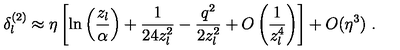


### Annotation

\delta _ { l } ^ { ( 2 ) } \approx \eta \left[ \operatorname { l n } \left( \frac { z _ { l } } \alpha \right) + \frac 1 { 2 4 z _ { l } ^ { 2 } } - \frac { q ^ { 2 } } { 2 z _ { l } ^ { 2 } } + O \left( \frac 1 { z _ { l } ^ { 4 } } \right) \right] + O ( \eta ^ { 3 } ) \ .




### Compiled Annotation

<IPython.core.display.Latex object>

In [ ]:
from IPython.display import display, Image, Markdown, Latex
from random import randint

class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '{0}'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'

i = randint(0,len(ds))
img_name,idx = ds[i]
img_filename = imgs_folder+img_name
label = labels[idx]
display(Markdown('### Input Image'))
display(Image(filename=img_filename))
display(Markdown('\n### Annotation'))
print(label)
display(Markdown('\n### Compiled Annotation'))
display(Latex("\Large "+label))

## Model


The model architecture consists of Deep CNN Encoder, followed by LSTM decoder with attention. 

We used the implementatoin provided by https://github.com/luopeixiang/im2latex as the baseline model. The reported results of the baseline model is:


## Prepare envirnoment

In [ ]:
%cd /content/drive/MyDrive/im2latex/im2latex

/content/drive/MyDrive/im2latex/im2latex


In [ ]:
!pip install -r requirements.txt
!pip install distance

  Using cached https://files.pythonhosted.org/packages/f6/1d/d925cfb4f324ede997f6d47bea4d9babba51b49e87a767c170b77005889d/nltk-3.4.5.zip
  Using cached https://files.pythonhosted.org/packages/ba/e0/46e2f0540370f2661b044647fa447fef2ecbcc8f7cdb4329ca2feb03fb23/numpy-1.17.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/da/2bd281c875686230eabc13d20ab590ea617563b0e746abfb0698c4d5b645/Pillow-6.1.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: Could not find a version that satisfies the requirement pkg-resources==0.0.0 (from -r requirements.txt (line 5)) (from versions: none)
ERROR: No matching distribution found for pkg-resources==0.0.0 (from -r requirements.txt (line 5))


In [ ]:
#transform data into pairs (Image tensor, annotation) and sort samples by image size
#!python preprocess.py --data_path /content/drive/MyDrive/im2latex/data/sample

In [ ]:
#!python build_vocab.py --data_path /content/drive/MyDrive/im2latex/data/sample

## Overfit on a single batch

In [ ]:
!python train.py \
    --data_path /content/drive/MyDrive/im2latex/data/sample \
    --dropout=0.2 \
    --add_position_features \
    --epoches=3 \
    --max_len=150 \
    --batch_size 32 \
    --train_on_single_batch

wandb: Currently logged in as: mariam (use `wandb login --relogin` to force relogin)
2021-05-16 07:11:15.590009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run fiery-blaze-76
wandb: ⭐️ View project at https://wandb.ai/mariam/im2latex
wandb: 🚀 View run at https://wandb.ai/mariam/im2latex/runs/u288deq7
wandb: Run data is saved locally in /content/drive/My Drive/im2latex/im2latex/wandb/run-20210516_071112-u288deq7
wandb: Run `wandb offline` to turn off syncing.

Training args: Namespace(add_position_features=True, batch_size=32, clip=2.0, cuda=True, data_path='/content/drive/MyDrive/im2latex/data/sample', dec_rnn_h=512, decay_k=1.0, dropout=0.2, emb_dim=80, epoches=3, from_check_point=False, lr=0.0003, lr_decay=0.5, lr_patience=3, max_len=150, min_lr=3e-05, print_freq=100, sample_method='teacher_forcing', save_dir='./ckpts', seed=2020, train_on_single_ba

## Train on a sample dataset

In [ ]:
!python train.py \
    --data_path /content/drive/MyDrive/im2latex/data/sample \
    --dropout=0.2 \
    --add_position_features \
    --epoches=20\
    --max_len=150 \
    --batch_size 16 \
    --wandb 


wandb: Currently logged in as: mariam (use `wandb login --relogin` to force relogin)
2021-05-16 10:43:03.056533: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run graceful-disco-79
wandb: ⭐️ View project at https://wandb.ai/mariam/im2latex
wandb: 🚀 View run at https://wandb.ai/mariam/im2latex/runs/18xuz1d2
wandb: Run data is saved locally in /content/drive/My Drive/im2latex/im2latex/wandb/run-20210516_104301-18xuz1d2
wandb: Run `wandb offline` to turn off syncing.

Training args: Namespace(add_position_features=True, batch_size=16, clip=2.0, cuda=True, data_path='/content/drive/MyDrive/im2latex/data/sample', dec_rnn_h=512, decay_k=1.0, dropout=0.2, emb_dim=80, epoches=20, from_check_point=False, lr=0.0003, lr_decay=0.5, lr_patience=3, max_len=150, min_lr=3e-05, print_freq=100, sample_method='teacher_forcing', save_dir='./ckpts', seed=2020, train_on_singl

## Model Evaluation

In [ ]:
!python  evaluate.py --split=test \
     --model_path=/content/drive/MyDrive/im2latex/ckpt-20-1.8869.pt \
     --data_path /content/drive/MyDrive/im2latex/data/sample/ \
     --batch_size 16\
     --ref_path=./results/ref.txt \
     --result_path=./results/result.txt \
     --beam_size 1\
     --num_workers 4

wandb: Currently logged in as: mariam (use `wandb login --relogin` to force relogin)
2021-05-16 10:06:30.415130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run lilac-serenity-78
wandb: ⭐️ View project at https://wandb.ai/mariam/im2latex
wandb: 🚀 View run at https://wandb.ai/mariam/im2latex/runs/1h5gnyjz
wandb: Run data is saved locally in /content/drive/My Drive/im2latex/im2latex/wandb/run-20210516_100628-1h5gnyjz
wandb: Run `wandb offline` to turn off syncing.

Traceback (most recent call last):
  File "evaluate.py", line 92, in <module>
    main()
  File "evaluate.py", line 43, in main
    checkpoint = torch.load(join(args.model_path))
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 592, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-package

In [ ]:
f = open(f'./results/result.txt')
result = f.readlines()
f.close()

In [ ]:
f = open(f'./results/ref.txt')
ref= f.readlines()
f.close()

In [ ]:
len(result),len(ref)

(10, 10)

In [ ]:
from IPython.display import display, Image, Markdown, Latex
from random import randint

class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '{0}'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'

i =randint(0,10)
t = ref[i]
p = result[i]
display(Markdown('\n### Reference'))
display(Latex("\Large "+t))
display(Markdown('\n### results'))
display(Latex("\Large "+p))


### Reference

<IPython.core.display.Latex object>


### results

<IPython.core.display.Latex object>

## References
- https://github.com/harvardnlp/im2markup
- https://github.com/luopeixiang/im2latex
- https://colab.research.google.com/drive/1XDtq-KT0GkX06a_g1MevuLFOMk4TxjKZ#scrollTo=JklaxjJ-f0dl

In [ ]:
# Preprocess images
# Crop images to get rid of the background.
# For a cropped image of size (w,h), we pad it with PAD_TOP, PAD_BOTTOM, PAD_LEFT, PAD_RIGHT, and the result is of size (w+PAD_LEFT+PAD_RIGHT, h+PAD_TOP+PAD_BOTTOM.
#downsample images.

import sys, os, argparse, json, glob, logging
import numpy as np
from PIL import Image
from image_utils import *


crop_blank_default_size='[600,60]',
pad_size=[8,8,8,8]# We pad the cropped image to the top, left, bottom, right with whitespace of size PAD_TOP, PAD_LEFT, PAD_BOTTOM, PAD_RIGHT
downsample_ratio=2


status = crop_image(filename, output_filename, crop_blank_default_size)
status = pad_group_image(output_filename, output_filename, pad_size, buckets)
status = downsample_image(output_filename, output_filename, downsample_ratio)
